In [ ]:
!pip install torchinfo

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict
import torch
from torch.utils.data import Dataset, DataLoader
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from torchsummary import summary
from torchinfo import summary
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import wandb
import torch.nn.functional as F
import hashlib
from typing import Dict, Tuple
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuration Dictionary
config = {
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 10,
    'input_dim': 9,
    'num_classes': 7,
    'hidden_dim': 512,
    'num_blocks': 3,
    'checkpoint_dir': "/content/drive/MyDrive/IDL/Checkpoint",
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [ ]:
# Define category mapping
CATEGORIES = {
    'Blueball': 0,
    'Box': 1,
    'Pencilcase': 2,
    'Pinkball': 3,
    'StuffedAnimal': 4,
    'Tennis': 5,
    'Waterbottle': 6,
}

In [ ]:
# Path to the folder containing the dataset files
folder_path = "/content/drive/MyDrive/IDL/IDL_Project"

In [ ]:
# Stats trackers
total_count = 0
kept_count = 0
valid_file_count = 0
skipped_due_to_missing_waypoints = 0

In [ ]:
WAYPOINTS = [
    (30, -30), (30, 30), (15, -30), (15, 30),
    (0, -30), (0, 30), (-15, -30), (-15, 30),
    (-30, -30), (-30, 30), (-30, -30), (30, -30),
    (30, 30), (-30, 30)
]


In [ ]:
# Step 1: Load and label dataset
def load_and_label_file(file_path, file_name):
    global total_count
    category = next((key for key in CATEGORIES if key in file_name), None)
    if category is None:
        return pd.DataFrame()

    data = []
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) == 10:
                try:
                    timestamp = parts[0]
                    sec = float(parts[1])/1000000 # convert microsec to sec for stability
                    x = float(parts[2])
                    y = float(parts[3])
                    x_target = float(parts[4])
                    y_target = float(parts[5])
                    pwm1 = int(parts[6])
                    pwm2 = int(parts[7])
                    pwm3 = int(parts[8])
                    pwm4 = int(parts[9])
                    total_count += 1

                    data.append([
                        timestamp, sec, x, y, x_target, y_target,
                        pwm1, pwm2, pwm3, pwm4, category, CATEGORIES[category]
                    ])
                except ValueError:
                    continue

    return pd.DataFrame(data, columns=[
        "timestamp", "seconds", "x", "y", "x_target", "y_target",
        "pwm1", "pwm2", "pwm3", "pwm4", "category", "label"
    ])

In [ ]:
# Step 2: Assign sequential waypoint numbers
def assign_sequential_waypoints(df, tol=1.0):
    df = df.reset_index(drop=True)
    wp_index = 0
    assigned_wp = []

    for i in range(len(df)):
        x_t, y_t = df.loc[i, "x_target"], df.loc[i, "y_target"]
        current_expected = WAYPOINTS[wp_index]

        if np.isclose(x_t, current_expected[0], atol=tol) and np.isclose(y_t, current_expected[1], atol=tol):
            assigned_wp.append(wp_index)
        else:
            if wp_index + 1 < len(WAYPOINTS):
                next_expected = WAYPOINTS[wp_index + 1]
                if np.isclose(x_t, next_expected[0], atol=tol) and np.isclose(y_t, next_expected[1], atol=tol):
                    wp_index += 1
                    assigned_wp.append(wp_index)
                else:
                    assigned_wp.append(wp_index)
            else:
                assigned_wp.append(wp_index)

    df["waypoint_number"] = assigned_wp
    return df

In [ ]:
# Step 3: Filter out rows where y <= 0
def filter_by_y(df):
    global kept_count
    filtered = df[df["y"] > 0].reset_index(drop=True)
    kept_count += len(filtered)
    return filtered

In [ ]:
def process_file(file_path, file_name):
    global valid_file_count

    # Step 1: Load and label
    df = load_and_label_file(file_path, file_name)
    if df.empty:
        return pd.DataFrame()

    # Step 2: Assign waypoint numbers
    df = assign_sequential_waypoints(df)

    # 📌 Show how many waypoints existed before filtering
    waypoint_count_before = df["waypoint_number"].nunique()
    print(f"\n📌 {file_name} → {waypoint_count_before} waypoints BEFORE filtering")

    # Step 3: Filter out rows where y ≤ 0
    df = filter_by_y(df)

    # 📌 Show how many remain after filtering
    waypoint_count_after = df["waypoint_number"].nunique()
    print(f"📌 {file_name} → {waypoint_count_after} waypoints AFTER filtering")

    # Count as valid if any data was kept
    if not df.empty:
        valid_file_count += 1

    return df

In [ ]:
# # Step 5: Process all .txt files
# all_data = pd.DataFrame()

# for file_name in os.listdir(folder_path):
#     if not file_name.endswith(".txt") or file_name.startswith("."):
#         continue
#     file_path = os.path.join(folder_path, file_name)
#     df = process_file(file_path, file_name)
#     if not df.empty:
#         all_data = pd.concat([all_data, df], ignore_index=True)

# # Step 6: Summary
# print("\n📄 Summary:")
# print(f"Total files scanned: {len([f for f in os.listdir(folder_path) if f.endswith('.txt')])}")
# print(f"✅ Files with 14 valid waypoints: {valid_file_count}")
# print(f"⚠️ Skipped due to missing waypoints: {skipped_due_to_missing_waypoints}")
# print(f"📊 Data points before filtering: {total_count}")
# print(f"✅ Data points after filtering: {kept_count}")
# print(f"🚫 Dropped data points: {total_count - kept_count}")

In [ ]:
# print(all_data.head(1350))

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np

In [ ]:
# class ObjectSensorDataset(Dataset):
#     def __init__(self, df):
#         features = df[["x", "y", "x_target", "y_target", "pwm1", "pwm2", "pwm3", "pwm4", "microseconds"]].values
#         labels = df["label"].values

#         self.X = torch.tensor(features, dtype=torch.float32)
#         self.y = torch.tensor(labels, dtype=torch.long)

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

In [ ]:
# # Normalize features before split
# features_to_scale = ["x", "y", "x_target", "y_target", "pwm1", "pwm2", "pwm3", "pwm4", "microseconds"]
# scaler = StandardScaler()
# all_data[features_to_scale] = scaler.fit_transform(all_data[features_to_scale])

# # 🧪 Split into train/val/test with stratified sampling
# train_df, temp_df = train_test_split(
#     all_data, test_size=0.3, stratify=all_data["label"], random_state=42
# )
# val_df, test_df = train_test_split(
#     temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
# )

# # 📦 Create datasets
# train_dataset = ObjectSensorDataset(train_df)
# val_dataset = ObjectSensorDataset(val_df)
# test_dataset = ObjectSensorDataset(test_df)

In [ ]:
from collections import defaultdict, Counter

def build_datasets(data_dir: str):
    data_dir = Path(data_dir)
    file_paths = list(data_dir.glob("*.txt"))
    random.seed(42)

    # 1. Group files by object class
    class_to_files = defaultdict(list)
    for file_path in file_paths:
        for class_name in CATEGORIES:
            if class_name in file_path.name:
                class_to_files[class_name].append(file_path)
                break

    # 2. Stratified split (each class in train/val/test)
    train_files, val_files, test_files = [], [], []
    for class_name, files in class_to_files.items():
        random.shuffle(files)
        n = len(files)
        train_split = int(0.65 * n)
        val_split = int(0.85 * n)
        train_files += files[:train_split]
        val_files += files[train_split:val_split]
        test_files += files[val_split:]

    print("🔍 Per-class file counts:")
    for cls in CATEGORIES:
        print(f"  {cls:<15} → {len(class_to_files[cls])} total files")

    print("\n✅ Final split file counts:")
    print(f"Train: {len(train_files)}")
    print(f"Val:   {len(val_files)}")
    print(f"Test:  {len(test_files)}")

    # 3. Process each split
    def process_file_list(file_list):
        dfs = []
        for fp in file_list:
            df = process_file(fp, fp.name)
            if not df.empty:
                dfs.append(df)
        return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

    print("Processing train files")
    train_df = process_file_list(train_files)
    print("Processing validation files")
    val_df = process_file_list(val_files)
    print("Processing test files")
    test_df = process_file_list(test_files)

    return train_df, val_df, test_df


# 📦 Run everything
train_df, val_df, test_df = build_datasets(folder_path)

🔍 Per-class file counts:
  Blueball        → 30 total files
  Box             → 30 total files
  Pencilcase      → 30 total files
  Pinkball        → 30 total files
  StuffedAnimal   → 30 total files
  Tennis          → 30 total files
  Waterbottle     → 29 total files

✅ Final split file counts:
Train: 132
Val:   42
Test:  35
Processing train files

📌 Pencilcase5.txt → 14 waypoints BEFORE filtering
📌 Pencilcase5.txt → 13 waypoints AFTER filtering

📌 Pencilcase11.txt → 14 waypoints BEFORE filtering
📌 Pencilcase11.txt → 12 waypoints AFTER filtering

📌 Pencilcase6.txt → 14 waypoints BEFORE filtering
📌 Pencilcase6.txt → 12 waypoints AFTER filtering

📌 Pencilcase23.txt → 14 waypoints BEFORE filtering
📌 Pencilcase23.txt → 12 waypoints AFTER filtering

📌 Pencilcase28.txt → 14 waypoints BEFORE filtering
📌 Pencilcase28.txt → 12 waypoints AFTER filtering

📌 Pencilcase1.txt → 14 waypoints BEFORE filtering
📌 Pencilcase1.txt → 12 waypoints AFTER filtering

📌 Pencilcase16.txt → 14 waypoints BEFORE 

In [ ]:
class WindowedDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, seq_len: int = config['input_dim']):
        self.seq_len = seq_len
        self.df = df.reset_index(drop=True)

        # Select feature columns (change as needed)
        self.features = self.df[[
            "x", "y", "x_target", "y_target", "pwm1", "pwm2", "pwm3", "pwm4", "waypoint_number"
        ]].values.astype(np.float32)

        # Label per row (you can change this to majority/last of the window)
        self.labels = self.df["label"].values.astype(np.int64)

    def __len__(self):
        return len(self.df) - self.seq_len + 1

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_len]  # (seq_len, input_dim)
        y = self.labels[idx + self.seq_len - 1]
        x_tensor = torch.tensor(x, dtype=torch.float32)  # ✅ explicitly float32
        y_tensor = torch.tensor(y, dtype=torch.long)
        return x_tensor, y_tensor


seq_len = 2500  # adjust as needed

train_dataset = WindowedDataset(train_df, seq_len=seq_len)
val_dataset = WindowedDataset(val_df, seq_len=seq_len)
test_dataset = WindowedDataset(test_df, seq_len=seq_len)

batch_size = config["batch_size"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# # 📦 Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# for X_batch, y_batch in tqdm(train_loader, desc="🔁 Training"):
#     # Simulate training step
#     pass

# for X_batch, y_batch in tqdm(val_loader, desc="🔍 Validating"):
#     # Simulate validation step
#     pass

# for X_batch, y_batch in tqdm(test_loader, desc="🧪 Testing"):
#     # Simulate test step
#     pass

# # 📊 Summary of dataset sizes
# print("\n📊 Dataset Sizes:")
# print(f"🧠 Training set: {len(train_dataset)} samples")
# print(f"🧪 Validation set: {len(val_dataset)} samples")
# print(f"🧾 Test set: {len(test_dataset)} samples")

In [ ]:
# import torch
# import torch.nn as nn
# from torchinfo import summary

# class TimeDistributed(nn.Module):
#     """Applies a module over the time dimension (B, T, F) → applies to each T."""
#     def __init__(self, module):
#         super(TimeDistributed, self).__init__()
#         self.module = module

#     def forward(self, x):
#         # x: (B, T, F)
#         B, T, F = x.size()
#         x = x.contiguous().view(B * T, F)
#         x = self.module(x)
#         x = x.view(B, T, -1)
#         return x

# class ResidualBlock(nn.Module):
#     def __init__(self, dim):
#         super(ResidualBlock, self).__init__()
#         self.linear1 = TimeDistributed(nn.Linear(dim, dim))
#         self.bn1 = TimeDistributed(nn.BatchNorm1d(dim))
#         self.act1 = nn.ReLU()
#         self.drop1 = nn.Dropout(0.5)

#         self.linear2 = TimeDistributed(nn.Linear(dim, dim))
#         self.bn2 = TimeDistributed(nn.BatchNorm1d(dim))

#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         identity = x
#         out = self.linear1(x)
#         out = self.bn1(out)
#         out = self.act1(out)
#         out = self.drop1(out)

#         out = self.linear2(out)
#         out = self.bn2(out)

#         out += identity
#         return self.relu(out)

# class ResidualMLPClassifier(nn.Module):
#     def __init__(self, input_dim, num_classes, hidden_dim=2048, num_blocks=10):
#         super(ResidualMLPClassifier, self).__init__()

#         self.input_layer = nn.Sequential(
#             TimeDistributed(nn.Linear(input_dim, hidden_dim)),
#             TimeDistributed(nn.BatchNorm1d(hidden_dim)),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#         )

#         self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_dim) for _ in range(num_blocks)])

#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             TimeDistributed(nn.Linear(hidden_dim, 1024)),
#             TimeDistributed(nn.BatchNorm1d(1024)),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             TimeDistributed(nn.Linear(1024, 512)),
#             TimeDistributed(nn.BatchNorm1d(512)),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             TimeDistributed(nn.Linear(512, 256)),
#             TimeDistributed(nn.BatchNorm1d(256)),
#             nn.ReLU(),
#             TimeDistributed(nn.Linear(256, num_classes)),
#         )

#         self.softmax = nn.Softmax(dim=2)

#     def forward(self, x):
#         x = self.input_layer(x)
#         x = self.res_blocks(x)
#         feats = x
#         out = self.classifier(x)
#         out = self.softmax(out)
#         out = out[:, -1, :]
#         return {"feats": feats, "out": out}


In [ ]:
# import torch
# import torch.nn as nn

# class ResidualBlock(nn.Module):
#     def __init__(self, dim):
#         super(ResidualBlock, self).__init__()
#         self.block = nn.Sequential(
#             nn.Linear(dim, dim),
#             nn.BatchNorm1d(dim),
#             nn.GELU(),
#             nn.Dropout(0.5),
#             nn.Linear(dim, dim),
#             nn.BatchNorm1d(dim),
#         )
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         identity = x
#         out = self.block(x)
#         out += identity
#         return self.relu(out)


# class ResidualMLPClassifier(nn.Module):
#     def __init__(self, input_dim, num_classes, hidden_dim=2048, num_blocks=6):
#         super(ResidualMLPClassifier, self).__init__()
#         self.input_layer = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.GELU(),
#             nn.Dropout(0.5),
#         )

#         self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_dim) for _ in range(num_blocks)])

#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(hidden_dim, 512),
#             nn.BatchNorm1d(512),
#             nn.GELU(),
#             nn.Linear(512, num_classes),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         x = self.input_layer(x)
#         x = self.res_blocks(x)
#         feats = x
#         out = self.classifier(x)
#         return {"feats": feats, "out": out}

# model = ResidualMLPClassifier(input_dim=9, num_classes=7, hidden_dim = config['hidden_dim'], num_blocks = config['num_blocks']).to(config['device'])
# summary(model, input_size=(64, 9))  # for batch size 64

In [ ]:
# import torch
# import torch.nn as nn

# class RNNClassifier(nn.Module):
#     def __init__(self, input_dim, num_classes, hidden_dim=256, num_layers=2, dropout=0.5, rnn_type="lstm"):
#         super(RNNClassifier, self).__init__()

#         self.rnn_type = rnn_type.lower()
#         rnn_cls = {
#             "lstm": nn.LSTM,
#             "gru": nn.GRU,
#             "rnn": nn.RNN
#         }[self.rnn_type]

#         self.rnn = rnn_cls(
#             input_size=input_dim,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout if num_layers > 1 else 0,
#             bidirectional=False
#         )

#         self.classifier = nn.Sequential(
#             nn.Linear(hidden_dim, 256),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(128, num_classes)
#         )

#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         # x: (B, T, F)
#         out, _ = self.rnn(x)  # out: (B, T, H)
#         last_out = out[:, -1, :]  # last timestep (B, H)
#         logits = self.classifier(last_out)
#         probs = self.softmax(logits)
#         return {"feats": last_out, "out": probs}

# model = RNNClassifier(
#     input_dim=9,
#     num_classes=7,
#     hidden_dim=config['hidden_dim'],
#     num_layers=config['num_blocks'],  # or another config param
#     dropout=0.5,
#     rnn_type="lstm"
# ).to(config['device'])

# # For summary:
# from torchinfo import summary
# summary(model, input_data=torch.zeros(64, 30, 9).to(config['device']))

In [ ]:
# import torch
# import torch.nn as nn

# class CNNClassifier(nn.Module):
#     def __init__(self, input_dim, num_classes, dropout=0.5):
#         super(CNNClassifier, self).__init__()

#         self.conv_layers = nn.Sequential(
#             nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(64),
#             # nn.Dropout(0.3),
#             nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             # nn.Dropout(0.3),
#             nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(256),
#             # nn.Dropout(0.3),
#             nn.AdaptiveAvgPool1d(output_size=1)
#         )

#         self.classifier = nn.Sequential(
#             nn.Flatten(),  # from (B, 256, 1) to (B, 256)
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             # nn.Linear(512, 128),
#             # nn.ReLU(),
#             # nn.Dropout(dropout),
#             nn.Linear(128, num_classes)
#         )

#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         # x: (B, T, F) -> (B, F, T) for Conv1d
#         x = x.permute(0, 2, 1)
#         feats = self.conv_layers(x)  # (B, 256, 1)
#         logits = self.classifier(feats)  # (B, num_classes)
#         probs = self.softmax(logits)
#         return {"feats": feats.squeeze(-1), "out": probs}

# # Model initialization
# model = CNNClassifier(
#     input_dim=config['input_dim'],
#     num_classes=7,
#     dropout=0.5
# ).to(config['device'])

# # For summary
# from torchinfo import summary
# summary(model, input_data=torch.zeros(64, 30, config['input_dim']).to(config['device']))


In [ ]:
import torch
import torch.nn as nn

class CNNBiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, dropout=0.5, lstm_hidden_dim=128, lstm_num_layers=1):
        super(CNNBiLSTMClassifier, self).__init__()

        # Convolutional feature extractor
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Classifier
        # hidden_size * 2 (because bidirectional)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Args:
            x: (B, T, F) where
               B = batch size,
               T = sequence length (time),
               F = feature dimension (input_dim).
        """
        # CNN expects (B, F, T)
        x = x.permute(0, 2, 1)  # -> (B, input_dim, T)

        # Extract features with the CNN
        # output shape: (B, 256, T) after the last conv
        x = self.conv_layers(x)

        # LSTM expects (B, T, Features), so permute back
        x = x.permute(0, 2, 1)  # -> (B, T, 256)

        # Get all time-step outputs from BiLSTM
        lstm_out, (h, c) = self.lstm(x)
        # lstm_out.shape = (B, T, 2*lstm_hidden_dim) for bidirectional
        # h.shape = (2 * num_layers, B, lstm_hidden_dim)

        # Option 1: Take the hidden state from the final time step:
        # final_out = lstm_out[:, -1, :]  # shape: (B, 2*lstm_hidden_dim)

        # Option 2: Take the last hidden state from each of the forward and backward LSTM:
        # (often the same result as above in many LSTM implementations)
        final_forward = h[-2, :, :]  # (B, lstm_hidden_dim), last layer forward
        final_backward = h[-1, :, :] # (B, lstm_hidden_dim), last layer backward
        final_out = torch.cat((final_forward, final_backward), dim=1)  # (B, 2*lstm_hidden_dim)

        # Pass final_out through the classifier
        logits = self.classifier(final_out)
        probs = self.softmax(logits)

        return {"feats": final_out, "out": probs}


model = CNNBiLSTMClassifier(
    input_dim=config['input_dim'],
    num_classes=7,
    dropout=0.5,
    lstm_hidden_dim=128,
    lstm_num_layers=1
).to(config['device'])

from torchinfo import summary
summary(model, input_data=torch.zeros(64, 30, config['input_dim']).to(config['device']))


Layer (type:depth-idx)                   Output Shape              Param #
CNNBiLSTMClassifier                      [64, 7]                   --
├─Sequential: 1-1                        [64, 256, 30]             --
│    └─Conv1d: 2-1                       [64, 64, 30]              1,792
│    └─ReLU: 2-2                         [64, 64, 30]              --
│    └─BatchNorm1d: 2-3                  [64, 64, 30]              128
│    └─Conv1d: 2-4                       [64, 128, 30]             24,704
│    └─ReLU: 2-5                         [64, 128, 30]             --
│    └─BatchNorm1d: 2-6                  [64, 128, 30]             256
│    └─Conv1d: 2-7                       [64, 256, 30]             98,560
│    └─ReLU: 2-8                         [64, 256, 30]             --
│    └─BatchNorm1d: 2-9                  [64, 256, 30]             512
├─LSTM: 1-2                              [64, 30, 256]             395,264
├─Sequential: 1-3                        [64, 7]                  

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    loss_m = AverageMeter()
    acc_m = AverageMeter()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = data
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs['out'], y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        acc = accuracy(outputs['out'], y)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(loss_m.avg)),
            acc="{:.04f}%".format(float(acc_m.avg)),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr']))
        )
        batch_bar.update()

        del x, y, outputs, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    return loss_m.avg, acc_m.avg

In [ ]:
@torch.no_grad()
def validate_model(model, val_loader, criterion, class_names, device):
    model.eval()
    loss_m = AverageMeter()
    acc_m = AverageMeter()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    all_preds = []
    all_targets = []

    for i, data in enumerate(val_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs['out'], y)

        acc = accuracy(outputs['out'], y)[0].item()

        _, predicted = torch.max(outputs['out'], 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(loss_m.avg)),
            acc="{:.04f}%".format(float(acc_m.avg))
        )
        batch_bar.update()

        del x, y, outputs, loss
        torch.cuda.empty_cache()

    batch_bar.close()

    if class_names:
        print("\nPer-class Validation Accuracy:")
        per_class_acc = {}
        for i, class_name in enumerate(class_names):
            class_mask = (np.array(all_targets) == i)
            if np.sum(class_mask) > 0:
                class_correct = np.sum((np.array(all_preds)[class_mask] == i))
                class_total = np.sum(class_mask)
                acc_percent = 100 * class_correct / class_total
                print(f"  {class_name}: {acc_percent:.4f}% ({class_correct}/{class_total})")
                per_class_acc[f"val_acc_{class_name}"] = acc_percent

    return loss_m.avg, acc_m.avg

In [ ]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'metrics': metrics
    }, path)

In [ ]:
# Define CrossEntropyLoss as the criterion
criterion = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Initialize optimizer with AdamW
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    gamma = 0.5,
    step_size=3
)

In [ ]:
import wandb

# Intialize wandb
wandb.login(key="e768e7128db26d1cd8476eda26e045d5bf6b390d") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: louisplot (louisplot-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
run = wandb.init(
    name = "27run", ## Wandb creates random run names if you skip this field
    reinit = False, ### Allows reinitalizing runs when you re-run this cell
    #id = "", ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "object_classification", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [ ]:
# Training Loop
best_val_loss = float('inf')
best_val_acc = 0
class_names = list(CATEGORIES.keys())

for epoch in range(config['epochs']):
    print(f"\nEpoch {epoch + 1}/{config['epochs']}")

    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, config['device'])
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    val_loss, val_acc = validate_model(model, val_loader, criterion, class_names, config['device'])
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)
    curr_lr = optimizer.param_groups[0]['lr']

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model_path = os.path.join(config['checkpoint_dir'], 'best_model.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, best_model_path)
        wandb.save(best_model_path)
        print(f"Saved best model with validation loss: {best_val_loss:.4f} and accuracy: {best_val_acc:.2f}%")

    last_model_path = os.path.join(config['checkpoint_dir'], f'model_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), last_model_path)
    wandb.save(last_model_path)
    print(f"Saved model for epoch {epoch+1}")

    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'learning_rate': curr_lr
    }, step=epoch)

    print(f"End of Epoch {epoch+1}/{config['epochs']}")

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")


Epoch 1/10


Train Loss: 1.7638, Train Accuracy: 41.78%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Per-class Validation Accuracy:
  Blueball: 53.2283% (12539/23557)
  Box: 30.5633% (7845/25668)
  Pencilcase: 33.3220% (9758/29284)
  Pinkball: 42.1961% (10049/23815)
  StuffedAnimal: 25.8433% (7110/27512)
  Tennis: 49.0934% (12699/25867)
  Waterbottle: 16.9524% (3866/22805)
Validation Loss: 1.8178, Validation Accuracy: 35.77%


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best model with validation loss: 1.8178 and accuracy: 35.77%
Saved model for epoch 1
End of Epoch 1/10

Epoch 2/10


Train Loss: 1.4053, Train Accuracy: 83.26%



Per-class Validation Accuracy:
  Blueball: 57.8639% (13631/23557)
  Box: 33.1074% (8498/25668)
  Pencilcase: 47.5789% (13933/29284)
  Pinkball: 39.3575% (9373/23815)
  StuffedAnimal: 18.4029% (5063/27512)
  Tennis: 47.1218% (12189/25867)
  Waterbottle: 22.4381% (5117/22805)
Validation Loss: 1.8015, Validation Accuracy: 37.97%
Saved best model with validation loss: 1.8015 and accuracy: 37.97%
Saved model for epoch 2
End of Epoch 2/10

Epoch 3/10


Train Loss: 1.2928, Train Accuracy: 95.50%



Per-class Validation Accuracy:
  Blueball: 60.9670% (14362/23557)
  Box: 31.0348% (7966/25668)
  Pencilcase: 40.6434% (11902/29284)
  Pinkball: 46.0928% (10977/23815)
  StuffedAnimal: 32.9638% (9069/27512)
  Tennis: 43.3487% (11213/25867)
  Waterbottle: 23.2361% (5299/22805)
Validation Loss: 1.7859, Validation Accuracy: 39.64%
Saved best model with validation loss: 1.7859 and accuracy: 39.64%
Saved model for epoch 3
End of Epoch 3/10

Epoch 4/10


Train Loss: 1.2708, Train Accuracy: 97.87%



Per-class Validation Accuracy:
  Blueball: 71.6687% (16883/23557)
  Box: 26.5155% (6806/25668)
  Pencilcase: 48.5828% (14227/29284)
  Pinkball: 50.5144% (12030/23815)
  StuffedAnimal: 34.2105% (9412/27512)
  Tennis: 59.9296% (15502/25867)
  Waterbottle: 27.0993% (6180/22805)
Validation Loss: 1.7391, Validation Accuracy: 45.39%
Saved best model with validation loss: 1.7391 and accuracy: 45.39%
Saved model for epoch 4
End of Epoch 4/10

Epoch 5/10


Train Loss: 1.2638, Train Accuracy: 98.61%



Per-class Validation Accuracy:
  Blueball: 56.3527% (13275/23557)
  Box: 24.0143% (6164/25668)
  Pencilcase: 34.0220% (9963/29284)
  Pinkball: 55.0325% (13106/23815)
  StuffedAnimal: 32.1387% (8842/27512)
  Tennis: 44.7597% (11578/25867)
  Waterbottle: 27.6518% (6306/22805)
Validation Loss: 1.7983, Validation Accuracy: 38.77%
Saved model for epoch 5
End of Epoch 5/10

Epoch 6/10


Train Loss: 1.2608, Train Accuracy: 98.94%



Per-class Validation Accuracy:
  Blueball: 78.5881% (18513/23557)
  Box: 32.1061% (8241/25668)
  Pencilcase: 33.3151% (9756/29284)
  Pinkball: 43.6490% (10395/23815)
  StuffedAnimal: 24.1858% (6654/27512)
  Tennis: 54.9503% (14214/25867)
  Waterbottle: 24.4595% (5578/22805)
Validation Loss: 1.7777, Validation Accuracy: 41.11%
Saved model for epoch 6
End of Epoch 6/10

Epoch 7/10


Train Loss: 1.2575, Train Accuracy: 99.30%



Per-class Validation Accuracy:
  Blueball: 72.1442% (16995/23557)
  Box: 28.8686% (7410/25668)
  Pencilcase: 42.2859% (12383/29284)
  Pinkball: 54.6546% (13016/23815)
  StuffedAnimal: 23.3244% (6417/27512)
  Tennis: 53.1488% (13748/25867)
  Waterbottle: 27.6168% (6298/22805)
Validation Loss: 1.7643, Validation Accuracy: 42.74%
Saved model for epoch 7
End of Epoch 7/10

Epoch 8/10


Train Loss: 1.2574, Train Accuracy: 99.31%



Per-class Validation Accuracy:
  Blueball: 80.0272% (18852/23557)
  Box: 17.1225% (4395/25668)
  Pencilcase: 47.7155% (13973/29284)
  Pinkball: 54.8478% (13062/23815)
  StuffedAnimal: 36.1297% (9940/27512)
  Tennis: 62.5546% (16181/25867)
  Waterbottle: 18.1802% (4146/22805)
Validation Loss: 1.7420, Validation Accuracy: 45.11%
Saved model for epoch 8
End of Epoch 8/10

Epoch 9/10


Train Loss: 1.2562, Train Accuracy: 99.45%



Per-class Validation Accuracy:
  Blueball: 72.6323% (17110/23557)
  Box: 38.5538% (9896/25668)
  Pencilcase: 45.9124% (13445/29284)
  Pinkball: 57.6359% (13726/23815)
  StuffedAnimal: 37.6236% (10351/27512)
  Tennis: 63.0262% (16303/25867)
  Waterbottle: 22.4249% (5114/22805)
Validation Loss: 1.7155, Validation Accuracy: 48.16%
Saved best model with validation loss: 1.7155 and accuracy: 48.16%
Saved model for epoch 9
End of Epoch 9/10

Epoch 10/10


Train Loss: 1.2559, Train Accuracy: 99.47%



Per-class Validation Accuracy:
  Blueball: 76.0284% (17910/23557)
  Box: 15.2369% (3911/25668)
  Pencilcase: 43.5528% (12754/29284)
  Pinkball: 65.5217% (15604/23815)
  StuffedAnimal: 33.6072% (9246/27512)
  Tennis: 49.9903% (12931/25867)
  Waterbottle: 12.9226% (2947/22805)
Validation Loss: 1.7698, Validation Accuracy: 42.17%
Saved model for epoch 10
End of Epoch 10/10

Training complete! Best validation accuracy: 48.16%


In [ ]:
@torch.no_grad()
def test_model(model, test_loader, criterion, class_names, device, checkpoint_dir=None):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_probs = []

    class_correct = {class_name: 0 for class_name in class_names}
    class_total = {class_name: 0 for class_name in class_names}

    for data in test_loader:
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        outputs_for_loss = outputs['out'] if isinstance(outputs, dict) and 'out' in outputs else outputs
        loss = criterion(outputs_for_loss, targets)
        test_loss += loss.item() * inputs.size(0)

        probs = torch.nn.functional.softmax(outputs_for_loss, dim=1)
        _, predicted = torch.max(outputs_for_loss, 1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        for i in range(targets.size(0)):
            label = targets[i].item()
            pred = predicted[i].item()
            class_name = class_names[label]
            class_total[class_name] += 1
            if pred == label:
                class_correct[class_name] += 1

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    class_accuracy = {
        name: class_correct[name]/class_total[name] if class_total[name] > 0 else 0
        for name in class_names
    }

    print("\n" + "="*50)
    print("TEST RESULTS")
    print("="*50)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f} ({correct}/{total})")
    print("\nPer-Class Accuracy:")
    for class_name in class_names:
        print(f" {class_name}: {class_accuracy[class_name]:.4f} ({class_correct[class_name]}/{class_total[class_name]})")

    return {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'class_accuracy': class_accuracy,
        'predictions': all_preds,
        'targets': all_targets,
        'probabilities': all_probs
    }


In [ ]:
best_model_path = f"{config['checkpoint_dir']}/best_model.pth"
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint.get('epoch', 'unknown')}")

Loaded best model from epoch 8


In [ ]:
results = test_model(model, test_loader, criterion, class_names, config['device'])


TEST RESULTS
Test Loss: 1.8304
Test Accuracy: 0.3520 (50381/143115)

Per-Class Accuracy:
 Blueball: 0.3942 (7392/18753)
 Box: 0.2359 (4628/19615)
 Pencilcase: 0.4940 (10076/20396)
 Pinkball: 0.6667 (12386/18577)
 StuffedAnimal: 0.3112 (7735/24859)
 Tennis: 0.3631 (7450/20516)
 Waterbottle: 0.0350 (714/20399)


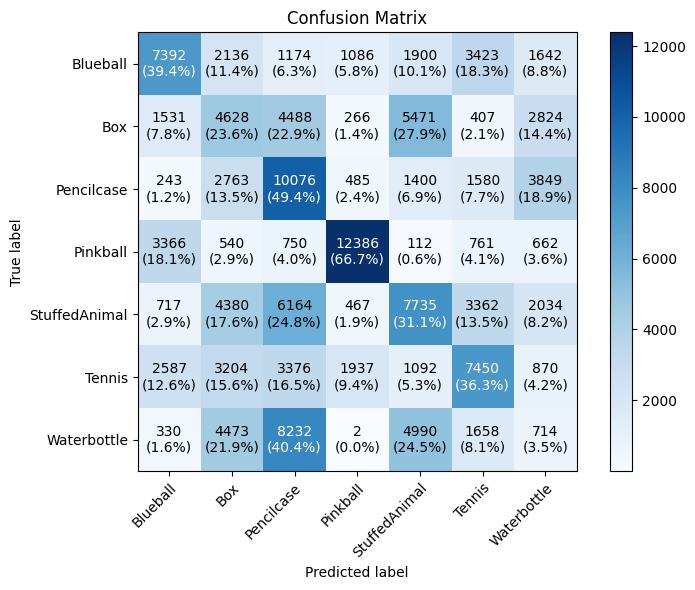

In [ ]:
# Count based confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch


# Convert to numpy if needed
class_names = list(CATEGORIES.keys())

# Convert tensors to numpy
preds = results['predictions']
targets = results['targets']
if isinstance(preds, torch.Tensor):
    preds = preds.cpu().numpy()
if isinstance(targets, torch.Tensor):
    targets = targets.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(targets, preds)
cm_sum = cm.sum(axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100

# Plot setup
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

# Labels, titles and ticks
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data to show count and percentage
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        perc = cm_perc[i, j]
        ax.text(j, i, f"{count}\n({perc:.1f}%)",
                ha="center", va="center",
                color="white" if count > thresh else "black")

plt.tight_layout()
plt.show()

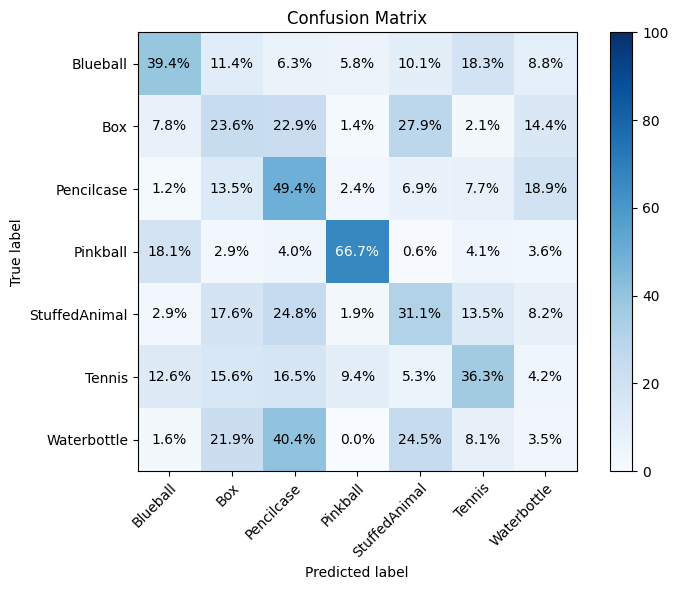

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

# Suppose CATEGORIES is a dict mapping integer labels to class names
# e.g., CATEGORIES = {0: 'cat', 1: 'dog', 2: 'horse'}
class_names = list(CATEGORIES.keys())

# Convert tensors to numpy if needed
preds = results['predictions']
targets = results['targets']
if isinstance(preds, torch.Tensor):
    preds = preds.cpu().numpy()
if isinstance(targets, torch.Tensor):
    targets = targets.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(targets, preds)
cm_sum = cm.sum(axis=1, keepdims=True)
# Percent matrix
cm_perc = cm / cm_sum.astype(float) * 100

# Compute approximate binomial standard error in percentage
# p = count/row_sum; se = sqrt(p*(1-p)/row_sum) * 100
p = np.divide(cm, cm_sum, out=np.zeros_like(cm, dtype=float), where=cm_sum!=0)
se_perc = np.sqrt(p * (1 - p) / np.maximum(cm_sum, 1)) * 100

# Plot setup
fig, ax = plt.subplots(figsize=(8, 6))

# Color the matrix by percentage, not raw counts
im = ax.imshow(cm_perc, interpolation='nearest', cmap='Blues', vmin=0, vmax=100)
ax.figure.colorbar(im, ax=ax)

# Labels, titles, and ticks
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Threshold to decide text color
threshold = 50  # or any value in [0,100] that works for your data

# Fill each cell with "XX.X% ± YY.Y%"
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cell_perc = cm_perc[i, j]
        cell_se = se_perc[i, j]
        # Choose text color based on background intensity
        color = "white" if cell_perc > threshold else "black"
        ax.text(
            j, i, f"{cell_perc:.1f}%",
            ha="center", va="center", color=color
        )

plt.tight_layout()
plt.show()


In [ ]:
run.finish()

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_acc,▁▆████████
train_loss,█▃▂▁▁▁▁▁▁▁
val_acc,▁▂▃▆▃▄▅▆█▅
val_loss,█▇▆▃▇▅▄▃▁▅
epoch,10
learning_rate,0.001
train_acc,99.47263
train_loss,1.25595
val_acc,42.17238
